In [4]:
import torch
import clip
from PIL import Image
import numpy as np


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)

image = preprocess(Image.fromarray(np.uint8(np.zeros((224, 224, 3))))).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "darkness"]).to(device)
print(image.min(),image.max())
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    print(image_features.shape, text_features.shape)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

tensor(-1.7923, device='cuda:0') tensor(-1.4802, device='cuda:0')
torch.Size([1, 512]) torch.Size([3, 512])
Label probs: [[0.7686  0.06018 0.1714 ]]


In [5]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [7]:
model, preprocess = clip.load("RN50x4", device=device)
preprocess

 92%|███████████████████████████████████▉   | 371M/402M [02:24<00:08, 3.82MiB/s]

: 

In [38]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class CrossAttentionTransformer(nn.Module):
    def __init__(self, q_dim,cross_attention_dim,embed_dim, num_heads=1,dropout=0.2):
        super(CrossAttentionTransformer, self).__init__()

        self.num_heads = num_heads
        self.head_dim = embed_dim 
        total_embed_dim = num_heads * embed_dim
        # Linear transformations for queries, keys, and values
        self.query_linear = nn.Linear(q_dim, total_embed_dim)
        self.key_linear = nn.Linear(cross_attention_dim, total_embed_dim)
        self.value_linear = nn.Linear(cross_attention_dim, total_embed_dim)
        self.dropout = nn.Dropout(dropout)
        # Output linear layer
        self.out_linear = nn.Linear(total_embed_dim,cross_attention_dim)

    def forward(self, x, conditional_x):
        batch_size, len_x, _     = x.size()
        _, len_conditional_x, _ = conditional_x.size()

        # Linear transformations
        query = self.query_linear(x)
        key   = self.key_linear(conditional_x)
        value = self.value_linear(conditional_x)

        # Reshape for multi-head attention
        query = query.view(batch_size, len_x            , self.num_heads, self.head_dim).transpose(1, 2)
        key   =   key.view(batch_size, len_conditional_x, self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch_size, len_conditional_x, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_dim ** 0.5)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)

        # Apply attention weights to values
        attended_values = torch.matmul(attention_weights, value)

        # Reshape and concatenate heads
        attended_values = attended_values.transpose(1, 2).contiguous().view(batch_size, len_x, -1)

        # Apply output linear layer
        output = self.out_linear(attended_values)
        output = self.dropout(output)
        output = output + x
        return output


In [39]:

# Example usage
batch_size = 2
sequence_length = 5*(512//8)
emp = 8
heads = 16
embed_dim = 8 


images_emps = torch.rand((2, sequence_length, emp))  # Batch size of 2, sequence length of 10, embedding dimension of 512
text_emp    = torch.rand((2, 64, emp))               # Batch size of 2, sequence length of 8, embedding dimension of 512

model = CrossAttentionTransformer(q_dim=emp, cross_attention_dim=emp,embed_dim=embed_dim, num_heads=heads)
output = model(images_emps, text_emp)
print(output.shape)  # Output shape: torch.Size([2, 10, 512])


torch.Size([2, 320, 8])


In [34]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class CrossAttentionTransformerMultiLayer(nn.Module):
    def __init__(self, num_layers,q_dim,cross_attention_dim,embed_dim, num_heads=1):
        super(CrossAttentionTransformerMultiLayer, self).__init__()

        self.layers = nn.ModuleList([
            CrossAttentionTransformer(q_dim=q_dim, cross_attention_dim=cross_attention_dim,embed_dim=embed_dim, num_heads=num_heads) for _ in range(num_layers)
        ])

    def forward(self, vectors1, vector2):
        for layer in self.layers:
            vectors1 = layer(vectors1, vector2)
        return vectors1


In [35]:
# Example usage
batch_size = 2
sequence_length = 5*(512//8)
emp = 8
heads = 16
embed_dim = 8 
layers = 2

images_emps = torch.rand((2, sequence_length, emp))  # Batch size of 2, sequence length of 10, embedding dimension of 512
text_emp    = torch.rand((2, 64, emp))               # Batch size of 2, sequence length of 8, embedding dimension of 512

model = CrossAttentionTransformerMultiLayer(num_layers=layers,q_dim=emp, cross_attention_dim=emp,embed_dim=embed_dim, num_heads=heads)
output = model(images_emps, text_emp)
print(output.shape)  # Output shape: torch.Size([2, 10, 512])

torch.Size([2, 320, 8])


In [ ]:

class CrossAttentionTransformerMultiLayer(nn.Module):
    def __init__(self, num_layers,q_dim,cross_attention_dim,embed_dim, num_heads=1,dropout=0.2):
        super(CrossAttentionTransformerMultiLayer, self).__init__()

        self.layers = nn.ModuleList([
            CrossAttentionLayer(q_dim=q_dim, cross_attention_dim=cross_attention_dim,embed_dim=embed_dim, num_heads=num_heads,dropout=dropout) for _ in range(num_layers)
        ])

    def forward(self,x, conditional_x):
        for layer in self.layers:
            x = layer(x, conditional_x)
        return x

class CrossAttentionEncoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.att_head_emp = args.att_head_emp
       
        self.encoder = CrossAttentionTransformerMultiLayer(num_layers=args.neck_layers,
                                                                q_dim=args.att_head_emp,
                                                                cross_attention_dim=args.att_head_emp,
                                                                embed_dim=args.att_head_emp,
                                                                num_heads=args.n_heads,
                                                                dropout=args.neck_dropout)
        
        self.flatten = nn.Flatten()
    def forward(self, input_x):
        images_emps,text_emps,pos_emps = input_x
        shape = images_emps.shape

        images_emps = images_emps.reshape(shape[0],-1,self.att_head_emp)
        text_emps   = text_emps.reshape(shape[0],-1,self.att_head_emp)
        images_emps  = self.encoder(images_emps,text_emps)
        images_emps = images_emps
        text_emps   = text_emps

        text_images_embeddings = torch.cat([images_emps,text_emps],dim=1)
        text_images_embeddings = self.flatten(text_images_embeddings)
        return torch.cat([text_images_embeddings,pos_emps],dim=1)
         
         
    

      
    def get_opt_params(self):
        return  [
            {"params": self.encoder.parameters()}
             ]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(CrossAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert (
            self.head_dim * num_heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(num_heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.num_heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.num_heads, self.head_dim)
        queries = query.reshape(N, query_len, self.num_heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.num_heads * self.head_dim
        )

        out = self.fc_out(out)
        return out


class CrossAttentionEncoderLayer(nn.Module):
    def __init__(self, embed_size, num_heads, ff_hidden_size, dropout):
        super(CrossAttentionEncoderLayer, self).__init__()
        self.cross_attention = CrossAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, ff_hidden_size),
            nn.ReLU(),
            nn.Linear(ff_hidden_size, embed_size),
        )
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, conditional_src, src_mask):
        cross_attended_src = self.cross_attention(src, conditional_src, src, src_mask)

        x = self.dropout(self.norm1(cross_attended_src + src))
        forward = self.feed_forward(x)

        out = self.dropout(self.norm2(forward + x))
        return out


class CrossAttentionEncoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        num_heads,
        ff_hidden_size,
        dropout,
        max_length,
    ):
        super(CrossAttentionEncoder, self).__init__()

        self.embed_size = embed_size
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                CrossAttentionEncoderLayer(
                    embed_size, num_heads, ff_hidden_size, dropout
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, conditional_src, mask):
        N, seq_length = src.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(device)
        src = self.dropout(self.word_embedding(src) + self.position_embedding(positions))

        for layer in self.layers:
            src = layer(src, conditional_src, mask)

        return src


In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(CrossAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert (
            self.head_dim * num_heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(num_heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values  = values.reshape(N, value_len, self.num_heads, self.head_dim)
        keys    = keys.reshape(N, key_len, self.num_heads, self.head_dim)
        queries = query.reshape(N, query_len, self.num_heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.num_heads * self.head_dim
        )

        out = self.fc_out(out)
        return out


class CrossAttentionEncoderLayer(nn.Module):
    def __init__(self, embed_size, num_heads, dropout):
        super(CrossAttentionEncoderLayer, self).__init__()
        self.cross_attention = CrossAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, conditional_src , src_mask=None):
        cross_attended_src = self.cross_attention(src, conditional_src, src, src_mask)

        x = self.dropout(self.norm1(cross_attended_src + src))
        forward = self.feed_forward(x)

        out = self.dropout(self.norm2(forward + x))
        return out


class CrossAttentionEncoder(nn.Module):
    def __init__(
        self,
        embed_size,
        num_layers,
        num_heads,
        dropout,
        max_length,
    ):
        super(CrossAttentionEncoder, self).__init__()

        self.embed_size = embed_size
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                CrossAttentionEncoderLayer(
                    embed_size, num_heads, dropout
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, conditional_src, mask=None):
        N, seq_length,emps = src.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length)
        src = self.dropout(src + self.position_embedding(positions))

        for layer in self.layers:
            src = layer(src, conditional_src, mask)

        return src


In [71]:
src      = torch.zeros((2, 5, 512))
cond_src = torch.zeros((2, 1, 512))


model = CrossAttentionEncoder(embed_size=512,num_layers=2, num_heads=8, dropout=0.1,max_length=5)

model(cond_src,src).shape


torch.Size([2, 5, 512])

In [6]:
import torch
from transformers import PerceiverModel, PerceiverConfig
class CrossAttentionPerceiver(torch.nn.Module):
    def __init__(self, config):
        super(CrossAttentionPerceiver, self).__init__()

        self.perceiver = PerceiverModel(config)
        
    def forward(self, input1, input2, attention_mask1=None, attention_mask2=None):
        """
        Args:
            input1: Input tensor for the first sequence.
            input2: Input tensor for the second sequence.
            attention_mask1: Attention mask for the first sequence (optional).
            attention_mask2: Attention mask for the second sequence (optional).
        Returns:
            outputs: Model outputs.
        """
        # Assuming both inputs have the same sequence length
        input_shape = input1.size()

        # Combine the two sequences
        combined_input = torch.cat([input1, input2], dim=1)

        # Combine the attention masks if provided
        if attention_mask1 is not None and attention_mask2 is not None:
            combined_attention_mask = torch.cat([attention_mask1, attention_mask2], dim=1)
        else:
            combined_attention_mask = None

        # Forward pass through the Perceiver model
        outputs = self.perceiver(
            inputs_embeds=combined_input,
            attention_mask=combined_attention_mask
        )

        return outputs

# Example usage:
config = PerceiverConfig()
cross_attention_perceiver = CrossAttentionPerceiver(config)

# Dummy input tensors
input1 = torch.randn(1, 10, 768)  # Sequence length of 10, assuming embedding size is 768
input2 = torch.randn(1, 10, 768)

# Forward pass
outputs = cross_attention_perceiver(input1, input2)
print(outputs)


ImportError: cannot import name 'PerceiverModel' from 'transformers' (unknown location)

In [10]:
# Dummy input tensors
from torch import nn
import torch 
model = torch.nn.MultiheadAttention(512,8)
input1 = torch.randn(1, 10,2, 512)  # Sequence length of 10, assuming embedding size is 768
input2 = torch.randn(1, 10, 512)
#position_embedding = nn.Embedding(20, 512)
#positions = torch.arange(0, 10).expand(1, 10)
#input1 = input1 + position_embedding(positions)

model(query=input1,key=input2,value=input2)

AssertionError: query should be unbatched 2D or batched 3D tensor but received 4-D query tensor

In [18]:

class CrossAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(CrossAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert (
            self.head_dim * num_heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values  = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys    = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out  = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        
        values = values.reshape(N, value_len, self.num_heads, self.head_dim)
        keys     = keys.reshape(N, key_len, self.num_heads, self.head_dim)
        queries = query.reshape(N, query_len, self.num_heads, self.head_dim)

        values  = self.values(values)
        keys    = self.keys(keys)
        queries = self.queries(queries)



        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.num_heads * self.head_dim
        )

        out = self.fc_out(out)
        return out


class CrossAttentionEncoderLayer(nn.Module):
    def __init__(self, embed_size, num_heads, dropout):
        super(CrossAttentionEncoderLayer, self).__init__()
        self.cross_attention = nn.MultiheadAttention(embed_size, num_heads, dropout=dropout,batch_first=True) 
        #CrossAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size),
        )
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, conditional_src , src_mask=None):
     

        cross_attended_src,attn_output_weights = self.cross_attention(query=src, key=conditional_src, value=conditional_src)
        
       
        x = self.dropout(self.norm1(cross_attended_src + src))
        forward = self.feed_forward(x)

        out = self.dropout(self.norm2(forward + x))
        return out


class CrossAttentionEncoder(nn.Module):
    def __init__(
        self,
        embed_size,
        num_layers,
        num_heads,
        dropout,
        max_length,
    ):
        super(CrossAttentionEncoder, self).__init__()

        self.embed_size = embed_size
        self.pos_encoder  = PositionalEncoding(embed_size, dropout=dropout, max_len=max_length)

        self.layers = nn.ModuleList(
            [
                CrossAttentionEncoderLayer(embed_size, num_heads, dropout) for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, conditional_src, mask=None):
        src = src.permute(1,0,2)
        conditional_src = conditional_src.permute(1,0,2)

        src = self.pos_encoder(src)

        for layer in self.layers:
            src = layer(src, conditional_src, mask)
        
        
        src = src.permute(1,0,2)

        return src


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        self.norm_3 = nn.LayerNorm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = nn.MultiheadAttention(heads, d_model)
        self.attn_2 = nn.MultiheadAttention(heads, d_model)
        self.ff = FeedForward(d_model).cuda()
def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs,
        src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output
# we don't perform softmax on the output as this will be handled 
# automatically by our loss function

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RelativeMSELoss(nn.Module):
    def __init__(self,mag_weight=0.005):
        super(RelativeMSELoss, self).__init__()
        self.mag_weight = mag_weight
    def forward(self, predicted, ground_truth):
        # Normalize sequences
        norm_predicted    = F.normalize(predicted, dim=-1)
        norm_ground_truth = F.normalize(ground_truth,dim=-1)

        # Calculate MSE on normalized sequences
        mse_loss = F.mse_loss(norm_predicted, norm_ground_truth)
        
        # calculate the magnitude of the predicted vector
        mag_predicted    = torch.norm(predicted, dim=-1)
        mag_ground_truth = torch.norm(ground_truth, dim=-1)
        mag_loss = F.mse_loss(mag_predicted, mag_ground_truth)

        print(norm_predicted)
        return mse_loss + self.mag_weight * mag_loss

# Example usage
predictions = (torch.tensor([1.0, 0.25, 1.0, 0], requires_grad=True)).unsqueeze(0)
ground_truth = torch.tensor([0.5, 0.25, 0.5, 0], requires_grad=False).unsqueeze(0)



print('norml mse loss:',F.mse_loss(predictions, ground_truth).item())
loss_function = RelativeMSELoss(0.01)
loss = loss_function(predictions.unsqueeze(0), ground_truth.unsqueeze(0))

print("Relative MSE Loss:", loss.item())

norml mse loss: 2475.20068359375
tensor([[[1.0000, 0.0080, 0.0100, 0.0000]]], grad_fn=<DivBackward0>)
Relative MSE Loss: 0.3055410087108612


In [68]:
predictions

tensor([[1.0000, 0.4621, 0.7616, 0.4621]], grad_fn=<TanhBackward0>)

In [89]:
x = torch.tensor([0.7, -0.35, 0.7, -0.35])
x = x/torch.max(x)
x

tensor([ 1.0000, -0.5000,  1.0000, -0.5000])

In [21]:
import clip
model, preprocess_image = clip.load('ViT-B/32',jit=False)
image_encoder = model.encode_image


In [34]:
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imgpath = 'generated_data/train/button-press-topdown-v2/0/1_0_4.jpg'
image  = Image.open(imgpath).convert('RGB')
image = preprocess_image(image).unsqueeze(0).to(device)


torch.Size([1, 3, 224, 224])


In [60]:
from torchviz import make_dot
target_model = model.visual

y = target_model(image.type(model.dtype))
# y = hidden_state @ target_model.proj , undo this projection
out = make_dot(y.mean(), params=dict(model.named_parameters()))
#save make_dot output as image
out.render("visualizations/clip_visual_transformer", format="png")

'visualizations/clip_visual_transformer.png'

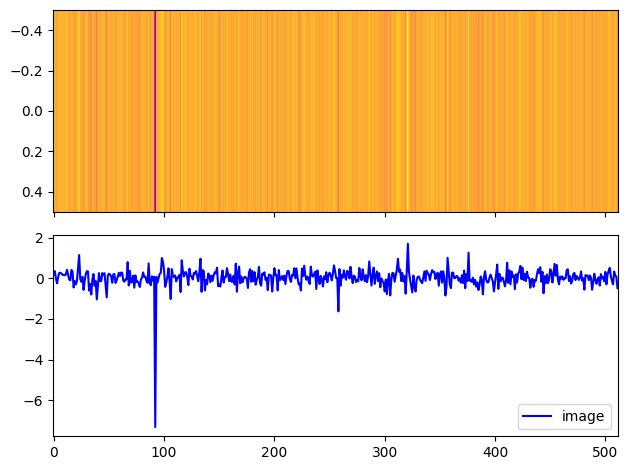

In [80]:
import matplotlib.pyplot as plt
y = target_model(image.type(model.dtype))
# y = hidden_state @ target_model.proj , undo this projection
#y = y @ target_model.proj.T
#plot y in a vector heatmap

data = y.cpu().detach().numpy()
x_axis = range(len(data[0]))


fig, (ax,ax2)= plt.subplots( nrows=2,sharex=True)

ax.imshow(data, cmap="plasma", aspect="auto")

ax2.plot(x_axis, data[0], "-b", label="image")
plt.legend(loc="lower right")
# plot the data vector in a ligand heatmap in ax2
#ax2.legend(x_axis,data)
plt.tight_layout()
plt.show()

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FiLMBlock(nn.Module):
    def __init__(self,vision_dim , instruct_dim):
        super(FiLMBlock, self).__init__()

        # Linear layers for conditioning
        self.conditioning_linear1 = nn.Linear(instruct_dim, vision_dim)
        self.conditioning_linear2 = nn.Linear(vision_dim, vision_dim * 2)  # Two times for scale and shift
        self.Relu = nn.ReLU()
    def forward(self, vision_embeddings, instruction_vector):
        # Apply conditioning
        conditioning_output = self.conditioning_linear1(instruction_vector)
        conditioning_output = self.Relu(conditioning_output)
        conditioning_output = self.conditioning_linear2(conditioning_output)

        # Split the conditioning output into scale and shift parameters

        scale , shift = torch.split(conditioning_output, vision_embeddings.size(1), dim=1)
      
        # Apply FiLM modulation
        vision_embeddings = vision_embeddings * scale + shift

        return vision_embeddings

class ResidualBlock(nn.Module):
    def __init__(self, vision_dim , instruct_dim):
        super(ResidualBlock, self).__init__()

        # FiLM block
        self.film_block = FiLMBlock(vision_dim , instruct_dim)

        self.Linear1 = nn.Linear(vision_dim,vision_dim)
                        
        self.Linear2 = nn.Linear(vision_dim,vision_dim)
        self.batch_norm = nn.BatchNorm1d(vision_dim)
        self.Relu = nn.ReLU()
     

    def forward(self, vision_embeddings, instruction_vector):
        
        vision_embeddings = self.Linear1(vision_embeddings)
        vision_embeddings = self.Relu(vision_embeddings)

        x = self.Linear2(vision_embeddings)
        x = self.batch_norm(x)
        x = self.film_block(x,instruction_vector)
        x = self.Relu(x)

        # Add the residual connection
        vision_embeddings += x
        return vision_embeddings

class Film(nn.Module):
    def __init__(self,N_blocks,vision_dim , instruct_dim):
        super(Film, self).__init__()

        self.blocks = []
        for i in range(N_blocks):
            self.blocks.append(ResidualBlock(vision_dim , instruct_dim))

        self.blocks = nn.ModuleList(self.blocks)
        self.flatten = nn.Flatten()
    def forward(self, input_x,cat=True):

        vision_embeddings, instruction_vector, pos_emps = input_x
        vision_embeddings = self.flatten(vision_embeddings)

        for block in self.blocks:
            vision_embeddings = block(vision_embeddings, instruction_vector)

        if not cat:
            return vision_embeddings,instruction_vector,pos_emps
        
        return torch.cat([vision_embeddings,instruction_vector,pos_emps],dim=1)
        
    def get_opt_params(self):
        return  [
            {"params": self.parameters()}
             ]


# Example usage:
cams =5
vision_dim = 512*cams  # Dimensionality of flattened vision embeddings
instruct_dim = 512  # Dimensionality of the hidden layer in the FiLM block

# Create Residual Block with FiLM
film = Film(4,vision_dim, instruct_dim)

# Dummy input tensors
vision_embeddings = torch.randn(32,vision_dim)  # Assuming 2D vision embeddings
instruction_vector = torch.randn(32, instruct_dim)
pos_vector         = torch.randn(32, 128)

# Forward pass through Residual Block
output_embeddings = film((vision_embeddings, instruction_vector, pos_vector))
print(output_embeddings.shape)  # Output shape: (32, input)

torch.Size([32, 3200])


In [3]:
import torch
batch_size = 4
seq_length = 5
feats = 10
returns_embeddings = torch.zeros((batch_size , seq_length , feats))
state_embeddings   = torch.ones((batch_size , seq_length , feats))
action_embeddings  = torch.zeros((batch_size , seq_length , feats)).fill_(2)
stacked_inputs = torch.stack(
            (returns_embeddings, state_embeddings, action_embeddings), dim=1
).permute(0, 2, 1, 3).reshape(batch_size, 3*seq_length, feats)


In [9]:
stacked_inputs[0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]])

In [45]:
#
import math
import torch
import torch.nn as nn

class LoRA(nn.Module):

    def __init__(self, length=0, pool_size =1,n_layer=1,embed_dim=128,top_k=1, dropout_rate=0.0, init_prompts="zeros",
                 rank=4, mod_q=True, mod_v=True, mod_k=False, mod_ff=True, 
                 lora_alpha=None, log_mod_stats=False, **kwargs):
        
        super().__init__()
        self.log_mod_stats = log_mod_stats
        self.rank = rank
        self.mod_v = mod_v
        self.mod_q = mod_q
        self.mod_k = mod_k
        self.mod_ff = mod_ff
        self.lora_alpha = lora_alpha if lora_alpha is not None else self.rank * 2
        self._scaling = self.lora_alpha / self.rank
        
        length = 10
        
        self.length = length
        self.pool_size = pool_size
        self.n_layer = n_layer
        self.embed_dim = embed_dim
        self._setup_prompt()

    @property
    def scaling(self):
        return self._scaling
        
    def _setup_prompt(self):
        self.lora_a = nn.Parameter(torch.zeros((self.pool_size, self.n_layer, self.length, self.embed_dim, self.rank)))
        self.lora_b = nn.Parameter(torch.zeros((self.pool_size, self.n_layer, self.length, self.rank, self.embed_dim)))
        nn.init.kaiming_uniform_(self.lora_a, a=math.sqrt(5))
        nn.init.zeros_(self.lora_b)
    
    def extract_prompt(self, idx):
        """
        Args:
            idx: torch.Tensor. Indices to lookup.

        """
        # idx: [batch_size x 1]
        # lora_a_batched: [n_layer x length x batch_size x rank x embed_dim]
        # lora_b_batched: [n_layer x length x batch_size x embed_dim x rank]
        lora_a_batched = self.lora_a[idx].permute(1,2,0,3,4)
        lora_b_batched = self.lora_b[idx].permute(1,2,0,3,4)
        lora_params = []
        for a,b in zip(lora_a_batched,lora_b_batched):
            qa,qb = a[0],b[0]
            va,vb = a[1],b[1]
            ffa1,ffb1 = a[2:3],b[2:6]
            ffa2,ffb2 = a[6:10],b[6:7]

            #permute mlp layers
            ffa1 = ffa1.permute(1,2,0,3).flatten(start_dim=1,end_dim=2)
            ffa2 = ffa2.permute(1,2,0,3).flatten(start_dim=1,end_dim=2)
            ffb1 = ffb1.permute(1,2,0,3).flatten(start_dim=2,end_dim=3)
            ffb2 = ffb2.permute(1,2,0,3).flatten(start_dim=2,end_dim=3)
            

            lora_params.append({
                'q_ba' : torch.matmul(qa,qb),
                'v_ba' : torch.matmul(va,vb),
                'ff1_ba': torch.matmul(ffa1,ffb1),
                'ff2_ba': torch.matmul(ffa2,ffb2)

            })
            
        return lora_params
    

    def add_dropout(self, batched_prompt):
        return batched_prompt

In [46]:
from torch import nn
import torch


lora = LoRA(pool_size=10,n_layer=3)
lora._setup_prompt()
idx = torch.tensor([1,2,3,4,5])

lora_params = lora.extract_prompt(idx)

for layer in lora_params:
    for k,v in layer.items():
        print(k,v.shape)


q_ba torch.Size([5, 128, 128])
v_ba torch.Size([5, 128, 128])
ff1_ba torch.Size([5, 128, 512])
ff2_ba torch.Size([5, 512, 128])
q_ba torch.Size([5, 128, 128])
v_ba torch.Size([5, 128, 128])
ff1_ba torch.Size([5, 128, 512])
ff2_ba torch.Size([5, 512, 128])
q_ba torch.Size([5, 128, 128])
v_ba torch.Size([5, 128, 128])
ff1_ba torch.Size([5, 128, 512])
ff2_ba torch.Size([5, 512, 128])


In [94]:
import torch
from torch import nn 
import torch.nn.functional as F
class keys_pool(nn.Module):
    def __init__(self, n_keys,d_dim,pool_size):
        super().__init__()
        self.key_encoder = nn.Embedding(n_keys,d_dim)
        # init the vector with mean 0 and std 1
        self.query = nn.Parameter(torch.randn((pool_size,d_dim)))
        #nn.init.normal_(self.query,mean=0,std=1)
    def forward(self,idx):
        encoded_keys = self.key_encoder(idx)
        #calculate cosine similarity
        #encoded_keys = encoded_keys / encoded_keys.norm(dim=-1, keepdim=True)
        #self.query   = self.query / self.query.norm(dim=-1, keepdim=True)
        #similarity = (100.0 * encoded_keys @ self.query.T).softmax(dim=-1)

        prompt_norm  = self.l2_normalize(self.query  , dim=1)  # Pool_size, C
        x_embed_norm = self.l2_normalize(encoded_keys, dim=1)  # B, C
        similarity = torch.matmul(x_embed_norm, prompt_norm.t())  # B, Pool_size

        return similarity
    @staticmethod
    def l2_normalize(x, dim=None, epsilon=1e-12):
        return torch.nn.functional.normalize(x, p=2.0, dim=dim, eps=epsilon)

d_dim = 128
n_keys = 10
pool_size = 100
k_pool = keys_pool(n_keys,d_dim,pool_size)

opt = torch.optim.Adam(k_pool.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


In [95]:
batch_size = 64
epochs = 1000

for epoch in range(epochs):
    idx = torch.randint(low=0,high=n_keys,size=(batch_size,))
    opt.zero_grad()
    out = k_pool(idx)
    loss = loss_fn(out,idx)
    loss.backward()
    opt.step()
print(loss.item())

3.3622171878814697


In [99]:
idx = torch.randint(low=0,high=n_keys,size=(10,))
out = k_pool(idx)
print(idx)
print(out.argmax(dim=1))

tensor([1, 0, 8, 7, 8, 5, 4, 4, 1, 0])
tensor([1, 0, 8, 7, 8, 5, 4, 4, 1, 0])


In [103]:
class keys_pool(nn.Module):
    def __init__(self, input_size,d_dim,pool_size):
        super().__init__()
        self.key_encoder = nn.Linear(input_size,d_dim)
        self.query       = nn.Parameter(torch.randn((pool_size,d_dim)))

    def forward(self,x):
        encoded_keys = self.key_encoder(x)
      
        prompt_norm  = self.l2_normalize(self.query  , dim=1)  # Pool_size, C
        x_embed_norm = self.l2_normalize(encoded_keys, dim=1)  # B, C
        similarity = torch.matmul(x_embed_norm, prompt_norm.t())  # B, Pool_size
        idx = torch.argmax(similarity, dim=1)
        return idx
    @staticmethod
    def l2_normalize(x, dim=None, epsilon=1e-12):
        return torch.nn.functional.normalize(x, p=2.0, dim=dim, eps=epsilon)
pool = keys_pool(128,128,100)
x = torch.randn((10,128))
out = pool(x)

In [105]:
out

tensor([11, 52, 47,  0, 52, 88,  6, 10, 71, 95])

In [3]:
from torch import nn
import torch

idx = torch.tensor([1,2,3,4,5])
success = torch.tensor([1,4])

mask = torch.zeros_like(idx)
success_idx = idx[idx in success]

tensor([ True, False, False, False, False])

In [9]:
A = torch.tensor([0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
B = torch.tensor([0,2, 5, 6, 8, 12, 15, 16])

exist = ((A.unsqueeze(1) == B).any(1))

exist

tensor([True, True, True, True, True, True, True, True, True, True, True])

In [13]:
import json 

def calculate_data_stats(data_dir):
    table=[]
    total_success_rate = 0
    for task_name , episodes in data_dir.items():
        task_success = 0
        for episode in episodes:
            task_success += episode[-1]['success']
        
        task_success_rate = float(task_success) / len(episodes)
        total_success_rate += task_success_rate
        print(task_name , task_success_rate)
        table.append([task_name,task_success_rate])
    table.append(['total_success_rate',total_success_rate/len(data_dir.items())])
    return table


data_dict_dir = '../out_dir/data/multi_levels/dataset_dict.json'


data_dir = json.load(open(data_dict_dir))
ret = calculate_data_stats(data_dir)
ret = ret[:-1]
print(ret)

button-press-topdown-v2 0.7027027027027027
button-press-v2 0.8772123893805309
door-lock-v2 0.8906666666666667
door-open-v2 0.8652094717668488
drawer-open-v2 0.8191176470588235
window-open-v2 0.9146341463414634
faucet-open-v2 0.8350383631713555
faucet-close-v2 0.9190371991247265
handle-press-v2 0.8509389671361502
coffee-button-v2 0.7274096385542169
[['button-press-topdown-v2', 0.7027027027027027], ['button-press-v2', 0.8772123893805309], ['door-lock-v2', 0.8906666666666667], ['door-open-v2', 0.8652094717668488], ['drawer-open-v2', 0.8191176470588235], ['window-open-v2', 0.9146341463414634], ['faucet-open-v2', 0.8350383631713555], ['faucet-close-v2', 0.9190371991247265], ['handle-press-v2', 0.8509389671361502], ['coffee-button-v2', 0.7274096385542169]]


In [19]:
import numpy as np
dataset_mean = np.mean([x[1] for x in ret])
dataset_std = np.std([x[1] for x in ret])
print(dataset_mean,dataset_std)
dataset = {x[0]:x[1] for x in ret}

0.8401967191903486 0.06965028858842191


In [20]:
import glob
def get_dict(dir):
    data_dir = json.load(open(dir))
    ret = {}
    for task,vs in data_dir.items():
        ret[task] = np.mean([v for v in vs.values()])
    return ret

def merge_multiple_dict(main_dir):
    dirs = glob.glob(main_dir + '/*.json')
    ret = {}
    for dir in dirs:
        d = get_dict(dir)
        for k ,v in d.items():
            if k in ret:
                ret[k].append(v)
            else:
                ret[k] = [v]
    for k,v in ret.items():
        ret[k] = np.mean(v)
    return ret
    

In [21]:
base_dir ='checkpoints/base_2cams/' 
film_dir ='checkpoints/film_neck2_2cams/' 
dt_dir ='checkpoints/dt/env/'

base_dict = merge_multiple_dict(base_dir)
film_dict = merge_multiple_dict(film_dir)
dt_dict = merge_multiple_dict(dt_dir)

#mean and std
base_mean = np.mean([x for x in base_dict.values()])
base_std = np.std([x for x in base_dict.values()])

film_mean = np.mean([x for x in film_dict.values()])
film_std = np.std([x for x in film_dict.values()])

dt_mean = np.mean([x for x in dt_dict.values()])
dt_std = np.std([x for x in dt_dict.values()])
print('base',base_mean,base_std)
print('film',film_mean,film_std)
print('dt',dt_mean,dt_std)

base 0.7433333333333334 0.09032861816312288
film 0.8644444444444443 0.0796287682985285
dt 0.8766666666666667 0.06674994798166929


In [58]:
#bar plot for the results of dataset and methods
import matplotlib.pyplot as plt
x_axis = ['\n'+task.replace('-v2','').replace('-','\n') for task in base_dict.keys()]
print(x_axis)
X = np.arange(len(x_axis))*1.2
offset = 0.2
width = offset

#font size 
plt.rcParams.update({'font.size': 150})

#plot size 
plt.figure(figsize=(150, 60))
plt.bar(X-1.5*offset,dataset.values()  ,label='Dataset' , width=width)
plt.bar(X-0.5*offset,base_dict.values(),label='CLIP'    , width=width)
plt.bar(X+0.5*offset,film_dict.values(),label='CLIP+FiLM'    , width=width)
plt.bar(X+1.5*offset,dt_dict.values()  ,label='Instruct DT'      , width=width)

plt.xticks(X, x_axis)
#add legand
plt.legend(bbox_to_anchor=(1, 1.15), loc='upper right', fontsize=160)
plt.show()


['\nbutton\npress\ntopdown', '\nbutton\npress', '\ndoor\nlock', '\ndoor\nopen', '\ndrawer\nopen', '\nwindow\nopen', '\nfaucet\nopen', '\nfaucet\nclose', '\nhandle\npress', '\ncoffee\nbutton']
